In [1]:
from typing import Optional

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

BASEMAP_SOURCE = cx.providers.CartoDB.VoyagerNoLabels

with open("../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)


def plot_grid(
    grid: gpd.GeoDataFrame, column: str, cmap: str, missing_kwds: Optional[dict] = None
) -> tuple[plt.Figure, plt.Axes]:
    fig = plt.figure(figsize=(4 * x_ratio, 4 * y_ratio))
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    grid.plot(column=column, cmap=cmap, aspect=None, ax=ax, missing_kwds=missing_kwds)
    ax.axis("off")
    ax.margins(0)
    fig.patch.set_visible(False)
    return fig, ax


def plot_grid_on_map(
    grid: gpd.GeoDataFrame, column: str, cmap: str, missing_kwds: Optional[dict] = None
) -> tuple[plt.Figure, plt.Axes]:
    fig = plt.figure(figsize=(4 * x_ratio, 4 * y_ratio))
    ax = fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    grid.plot(
        column=column,
        cmap=cmap,
        aspect=None,
        ax=ax,
        alpha=0.75,
        missing_kwds=missing_kwds,
    )
    cx.add_basemap(
        ax,
        crs=CRS,
        source=cx.providers.CartoDB.VoyagerNoLabels,
        alpha=1,
        attribution=False,
    )
    ax.axis("off")
    ax.margins(0)
    fig.patch.set_visible(False)
    return fig, ax

In [2]:
CRS = 2449
x_ratio = 0.9
y_ratio = 1.1

In [4]:
grid = gpd.read_file(f"../output/grid_bl_{CRS}.geojson", engine="pyogrio")
grid.set_crs(CRS, inplace=True)

activity = pd.read_csv("../output/activity.csv", engine="pyarrow")
unique_users = pd.read_csv("../output/unique_users.csv", engine="pyarrow")

In [5]:
activity["activity_count_log"] = activity["count"].apply(np.log10).fillna(0)
unique_users["users_count_log"] = unique_users["count"].apply(np.log10).fillna(0)

In [8]:
grid2 = grid.merge(
    activity[["x", "y", "activity_count_log"]], on=["x", "y"], how="left"
)
grid2["activity_count_log"] = grid2["activity_count_log"].fillna(0)

grid2 = grid2.merge(
    unique_users[["x", "y", "users_count_log"]], on=["x", "y"], how="left"
)
grid2["users_count_log"] = grid2["users_count_log"].fillna(0)

grid2 = grid2.merge(activity[["x", "y", "count"]], on=["x", "y"], how="left")
grid2.rename({"count": "activity_count"}, axis=1, inplace=True)
grid2 = grid2.merge(unique_users[["x", "y", "count"]], on=["x", "y"], how="left")
grid2.rename({"count": "users_count"}, axis=1, inplace=True)

In [9]:
grid2["users_count_log_bin"] = grid2["users_count"].apply(lambda x: 0 if x < 75 else 1)

grid2["users_count_log_selective"] = grid2.apply(
    lambda x: np.NaN
    if x["activity_count"] < 75 or pd.isna(x["activity_count"])
    else x["users_count_log"],
    axis=1,
)
grid2["activity_count_log_selective"] = grid2.apply(
    lambda x: np.NaN
    if x["activity_count"] < 75 or pd.isna(x["activity_count"])
    else x["activity_count_log"],
    axis=1,
)

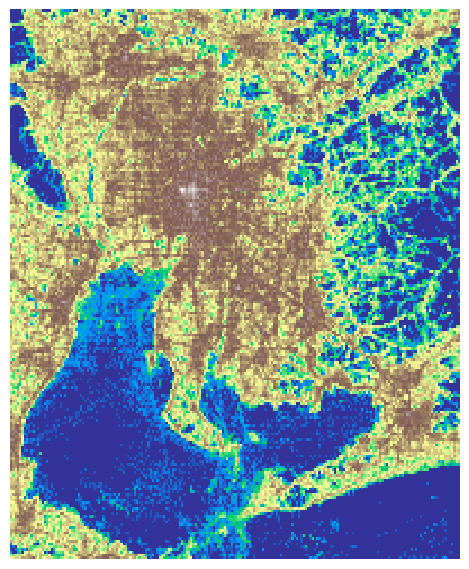

In [13]:
fig, _ = plot_grid(grid2, "activity_count_log", "terrain")
for i in config["formats"]:
    fig.savefig(
        f"../figures/activity_terrain_{CRS}.{i}",
        dpi=120,
        pad_inches=0,
        metadata=config["metadata"],
    )

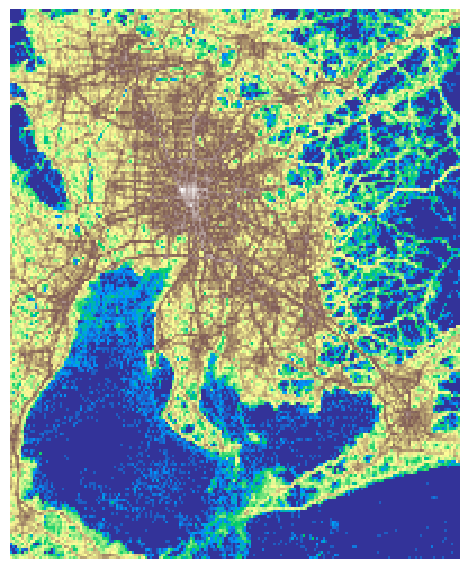

In [12]:
fig, _ = plot_grid(grid2, "users_count_log", "terrain")
for i in config["formats"]:
    fig.savefig(
        f"../figures/user_count_terrain_{CRS}.{i}",
        dpi=120,
        pad_inches=0,
        metadata=config["metadata"],
    )

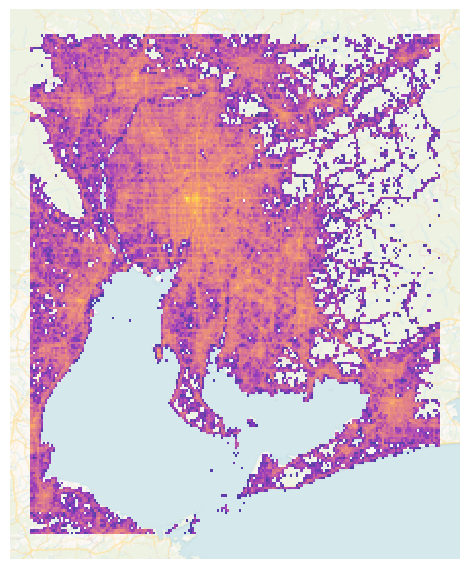

In [59]:
fig, _ = plot_grid_on_map(
    grid2,
    "activity_count_log_selective",
    "plasma",
    missing_kwds={"color": "none", "edgecolor": "none"},
)
for i in config["formats"]:
    fig.savefig(
        f"../figures/activity_count_log_on_map_{CRS}.{i}",
        dpi=120,
        pad_inches=0,
        metadata=config["metadata"],
    )

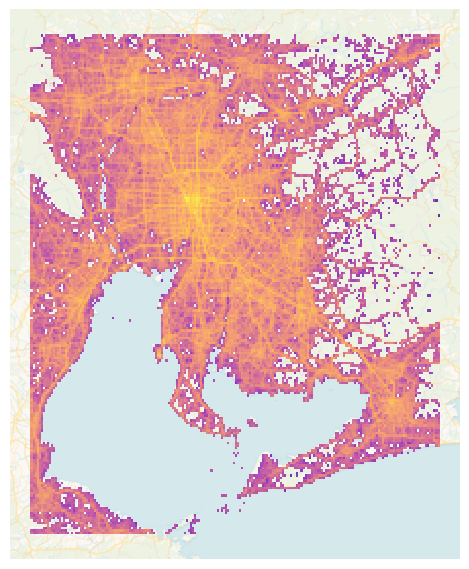

In [60]:
fig, _ = plot_grid_on_map(
    grid2,
    "users_count_log_selective",
    "plasma",
    missing_kwds={"color": "none", "edgecolor": "none"},
)
for i in config["formats"]:
    fig.savefig(
        f"../figures/users_count_log_on_map_{CRS}.{i}",
        dpi=120,
        pad_inches=0,
        metadata=config["metadata"],
    )